In [135]:
import collections
import seaborn as sns
import os
import glob
import numpy as np
from sklearn.decomposition import PCA
import math
import re
import pandas as pd
import nltk
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

Автоматический поиск произведений в папках texts/txt/\*\* (вместо \*\* — имя автора) и создание словарей *название-путь\_к\_файлу* (TITLE_PATH_DICT), *название-автор* (TITLE_AUTHOR_DICT), *автор-множество\_названий\_произведений* (AUTHOR__TITLE_SET__DICT).

In [2]:
FILE_PATHS = glob.glob('texts/converted/**/*.txt', recursive=True)

In [3]:
TITLE_PATH_DICT = {path.split("\\")[-1].split(".")[0] : path for path in FILE_PATHS}
TITLE_AUTHOR_DICT = {path.split("\\")[-1].split(".")[0] : path.split("\\")[-2] for path in FILE_PATHS}

In [4]:
AUTHOR__TITLE_SET__DICT = collections.defaultdict(set)
for title, author in TITLE_AUTHOR_DICT.items():
    AUTHOR__TITLE_SET__DICT[author].add(title)
AUTHOR__TITLE_SET__DICT = dict(AUTHOR__TITLE_SET__DICT)

In [15]:
CORPUS_WORD_COUNTER_FILENAME = 'corpus_word_counter.npy'
BOOK_WORD_COUNTERS_FILENAME = 'word_counters_2000.csv'

In [27]:
NPY_FOLDER = 'texts/5000_words_lemmatized/'

### ...

In [6]:
# feature_vectors.append((text_title + ' (' + TITLE_AUTHOR_DICT[text_title].upper() + ')', vector))
df = pd.DataFrame(columns=['title', 'author'])
i = 0
for title, author in TITLE_AUTHOR_DICT.items():
    df.loc[i] = [title, author]
    i += 1
df

,title,author
0,aktyorskaya-gibel,anton-chekhov
1,albom,anton-chekhov
2,antreprener-pod-divanom,anton-chekhov
3,anyuta,anton-chekhov
4,aptekarsha,anton-chekhov
...,...,...
126,zapiski-sumasshedshego,nikolai-gogol
127,zhenitba,nikolai-gogol
128,alenkii-cvetochek,sergey-aksakov
129,detskie-gody-bagrova-vnuka,sergey-aksakov


**Лемматизация**

In [7]:
import re

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

patterns = "[A-Za-z0-9!#$%&'()*+,.…/:;<=>?@[\]^_`{|}~—–\"«»„“\-]+"
morph = MorphAnalyzer()

def lemmatize(doc, remove_stop_words=False):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    stopwords_ru = stopwords.words("russian") if remove_stop_words else ''
    for token in doc.split():
        if token and token.strip() not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return tokens

In [8]:
if os.path.isfile(CORPUS_WORD_COUNTER_FILENAME):
    corpus_word_counter_lst_sorted = np.load(CORPUS_WORD_COUNTER_FILENAME)
    corpus_word_counter = dict(corpus_word_counter)
else:
    corpus_word_counter = collections.defaultdict(int)
    for title, path in tqdm(TITLE_PATH_DICT.items()):
        with open(path, 'r', encoding="utf8") as infile:
            text = infile.read()
        for word in lemmatize(text):
            corpus_word_counter[word] += 1
    corpus_word_counter_lst_sorted = sorted(list(corpus_word_counter.items()), key=lambda x: -x[1])
    corpus_word_counter = dict(corpus_word_counter)
    np.save(CORPUS_WORD_COUNTER_FILENAME, corpus_word_counter_lst_sorted)

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [13:34<00:00,  6.22s/it]


In [16]:
if os.path.isfile(BOOK_WORD_COUNTERS_FILENAME):
    df_word_count = pd.read_csv(BOOK_WORD_COUNTERS_FILENAME, encoding = "utf-8")
else:
    df_word_count = df.copy()
    corpus_word_counter_lst_sorted_short = corpus_word_counter_lst_sorted[:2000]
    columns=[word for word, _ in corpus_word_counter_lst_sorted_short]
    for title, path in tqdm(list(TITLE_PATH_DICT.items())):
        book_word_counter = collections.defaultdict(int)
        with open(path, 'r', encoding="utf8") as infile:
            text = infile.read()
        tokens = lemmatize(text)
        for word in tokens:
            book_word_counter[word] += 1
        tmp_df = pd.DataFrame(
            [[book_word_counter[word] / len(tokens) for word, _ in corpus_word_counter_lst_sorted_short]], 
            columns=columns
        )
        df_word_count.loc[df_word_count.title == title, columns] = tmp_df.copy()
        for word, _ in corpus_word_counter_lst_sorted_short:
            df_word_count.loc[df_word_count.title == title, word] = book_word_counter[word] / len(tokens)
    df_word_count.to_csv(BOOK_WORD_COUNTERS_FILENAME, encoding = "utf-8", index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 131/131 [8:13:28<00:00, 226.02s/it]


In [17]:
df_word_count

,title,author,и,он,в,не,я,что,она,на,...,достойный,медный,хорошенько,смутить,мелькать,расчёт,опомниться,прятаться,производить,невинный
0,aktyorskaya-gibel,anton-chekhov,0.041111,0.026111,0.036667,0.020556,0.015000,0.020556,0.002778,0.015000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,albom,anton-chekhov,0.051322,0.043546,0.024883,0.020218,0.018663,0.012442,0.001555,0.009331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,antreprener-pod-divanom,anton-chekhov,0.033827,0.016913,0.022199,0.022199,0.030655,0.008457,0.017970,0.008457,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000
3,anyuta,anton-chekhov,0.043070,0.014096,0.024276,0.015662,0.006265,0.011746,0.017228,0.019577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,aptekarsha,anton-chekhov,0.042781,0.012701,0.026070,0.016043,0.006684,0.014037,0.017380,0.016711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,zapiski-sumasshedshego,nikolai-gogol,0.033553,0.014945,0.022711,0.027253,0.052161,0.025788,0.010696,0.015385,...,0.000000,0.000000,0.000440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
127,zhenitba,nikolai-gogol,0.027104,0.009184,0.017920,0.025760,0.022400,0.022997,0.007616,0.010603,...,0.000075,0.000000,0.000299,0.000000,0.000000,0.000000,0.000000,0.000075,0.000075,0.000000
128,alenkii-cvetochek,sergey-aksakov,0.065400,0.024036,0.021940,0.025713,0.020682,0.008944,0.022079,0.015651,...,0.000000,0.000279,0.000000,0.000000,0.000000,0.000000,0.000279,0.000000,0.000000,0.000000
129,detskie-gody-bagrova-vnuka,sergey-aksakov,0.055186,0.010605,0.026191,0.021125,0.035708,0.020482,0.014090,0.014336,...,0.000028,0.000104,0.000123,0.000085,0.000057,0.000028,0.000114,0.000038,0.000104,0.000000


## Подсчет слов и t-SNE

In [138]:
def make_word_count_df(n_top_words=2000, excerpt_mul=1):
    corpus_word_counter_lst_sorted_short = corpus_word_counter_lst_sorted[:n_top_words]
    columns=['author'] + [word for word, _ in corpus_word_counter_lst_sorted_short]

    df_npy_word_count = pd.DataFrame(columns=columns)

    num_of_npys = len(glob.glob(f'{NPY_FOLDER}/**/*.npy', recursive=True))
    with tqdm(total=num_of_npys) as pbar:
        for author in AUTHOR__TITLE_SET__DICT.keys():
            npy_paths = glob.glob(f'{NPY_FOLDER}/{author}/*.npy', recursive=True)
            for i in range(0, len(npy_paths), excerpt_mul):
                book_word_counter = collections.defaultdict(int)
                lemmas = []
                for npy_path in npy_paths[i:i+excerpt_mul]:
                    lemmas = np.concatenate([lemmas, np.load(npy_path)])
                for lemma in lemmas:
                    book_word_counter[lemma] += 1
                tmp_df = pd.DataFrame(
                    [[author] + [book_word_counter[lemma] / len(lemmas) for lemma, _ in corpus_word_counter_lst_sorted_short]], 
                    columns=columns
                )
                df_npy_word_count = pd.concat([df_npy_word_count, tmp_df], ignore_index=True)
                pbar.update(excerpt_mul)
    return df_npy_word_count

In [139]:
def word_count_tsne(n_top_words=2000, excerpt_mul=1):
    df_npy_word_count = make_word_count_df(n_top_words, excerpt_mul)
    
    df_npy_word_count_no_author = df_npy_word_count.copy()
    df_author_only = df_npy_word_count_no_author.pop("author")
    
    tsne = TSNE(n_components=2, learning_rate=100, random_state=273)
    tsne_results = tsne.fit_transform(df_npy_word_count_no_author)

    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne["label"] = df_author_only
    
    sns.lmplot(x="comp1", y="comp2", data=df_tsne, hue="label", fit_reg=False)
    plt.title(f"Топ-{n_top_words} слов. Длина отрывков {5000*excerpt_mul} слов.")
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 971/971 [00:08<00:00, 113.75it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


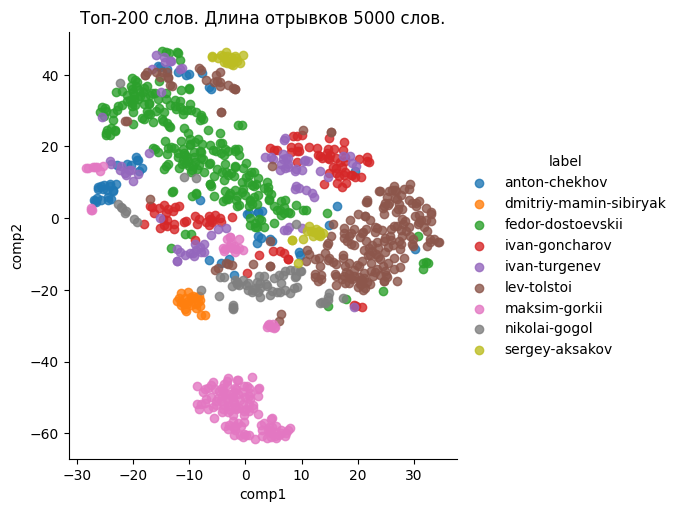

100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [00:21<00:00, 45.18it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


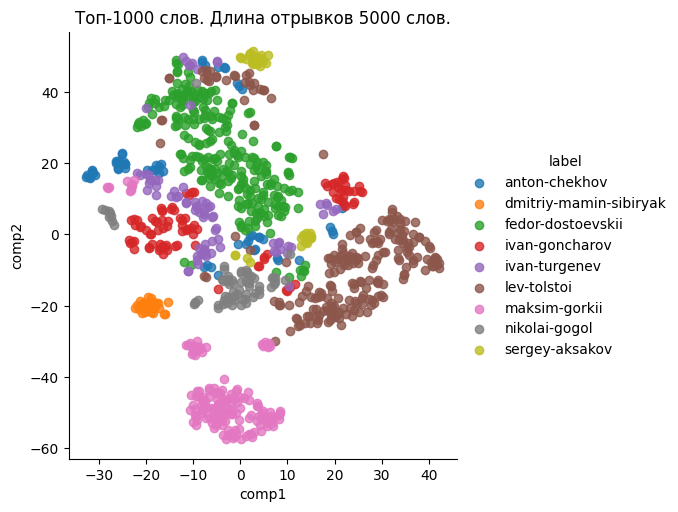

100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [00:37<00:00, 26.06it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


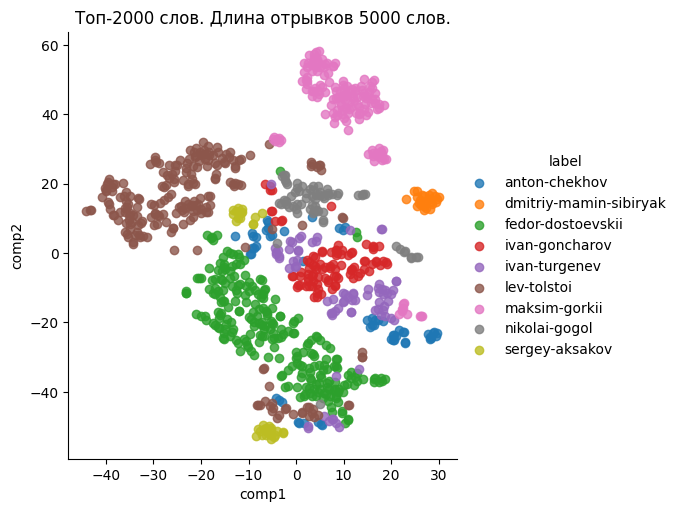

974it [00:10, 90.22it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


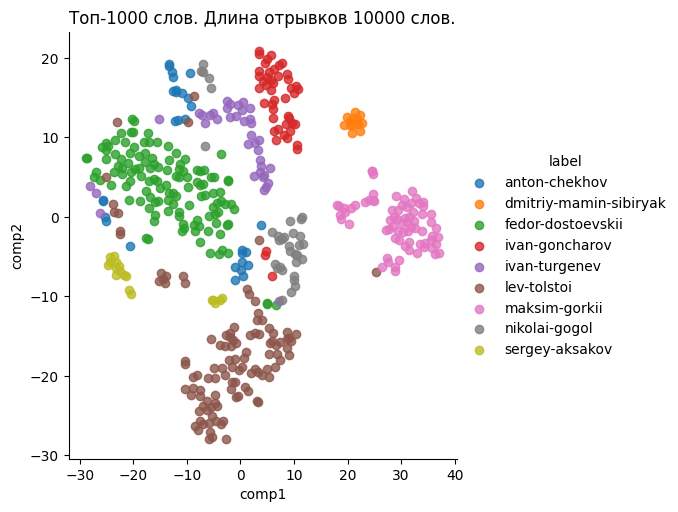

974it [00:18, 51.33it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


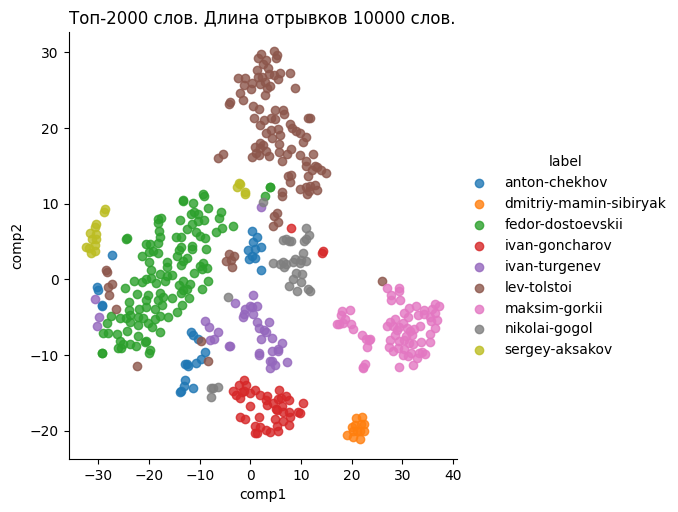

988it [00:03, 248.49it/s]                                                                                              
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


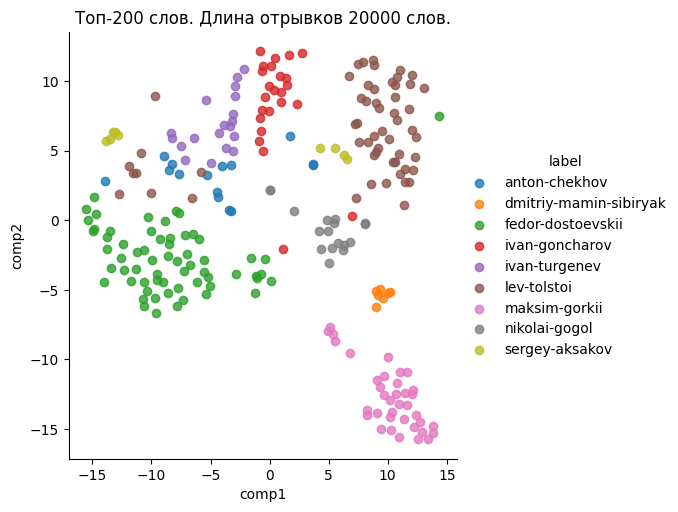

988it [00:13, 75.92it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


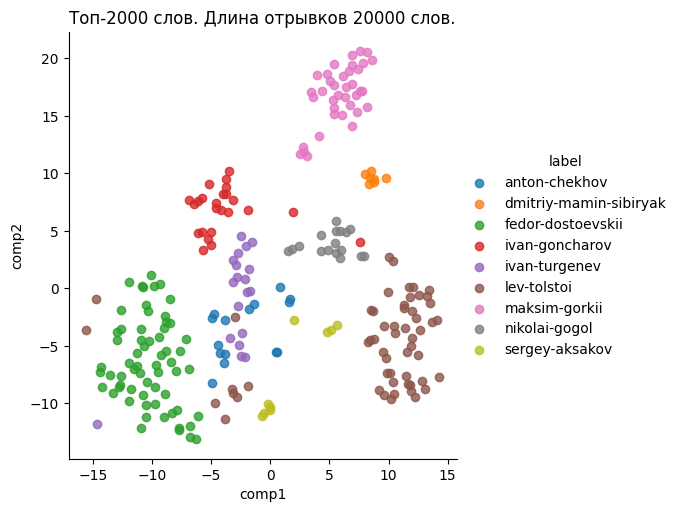

In [140]:
variants = [(200, 1), (1000, 1), (2000, 1), (1000, 2), (2000, 2), (200, 4), (2000, 4)]
for n_top_words, excerpt_mul in variants:
    word_count_tsne(n_top_words, excerpt_mul)